# Datasets generation and insights

This notebook investigates various ways of generating the training data and biases they entail.

The document `docs/report_for_github.pdf` explains the theory behind this. Four distinct schemes for generating data are discussed therein, numbered 1 to 4. We will situate those schemes in what follow, but it is not necessary to know about them to understand the notebook.

## Fixed temperature (fixed $T$) vs fixed second moment (fixed $s$)

We first we generate the relevant datasets. By default, the `dataset.py` script generates data with fixed temperature for randomly scaled real-axis conductivities. The key parameters we change are `--fixstd 8.86`, which fixes the second moment of all real-axis conductivities (the value 8.86 is used for retrocompatibility), and `--beta [0,60]` which samples temperature randomly, uniformly distributed between 0 and 60 (the default value is 30 otherwise). We omit the case in which one would set random temperatures without fixing the second moment, because it would not make sense, as discussed below.

Note that all these datasets are produced with the same random seeds, so they contain the exact same base functions.

In [3]:
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555;
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555 --fixstd 8.86;
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555 --fixstd 8.86 --beta [0,60];

100%|█████████████████████████████████████| 10000/10000 [03:30<00:00, 47.59it/s]


We then load the required modules and the datasets we just generated. 

In [9]:
import os

import numpy as np
import matplotlib.pyplot as plt

from deep_continuation.dataset import DATAPATH

pi = {}
pi['fixed T, random s'] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta30.npy"))
pi['fixed T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta30_std8.86.npy"))
pi['random T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta0to60_std8.86.npy"))

sigma = {}
sigma['fixed T, random s'] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20.npy"))
sigma['fixed T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20_std8.86.npy"))
sigma['random T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20_std8.86.npy"))

scale = np.load(os.path.join(DATAPATH, "default", "std_10000x1x1_seed555.npy"))


## Coverage of the input and output space

The main difference that fixing $T$ and/or fixing $s$ bring is the coverage in the input space (space of possible $\Pi(\omega_n)$) and output space (space of possible $\sigma(\omega)$). The plots below show that fixing T with random sigma lead to wide coverage in both spaces.
 - Base coverage is wide in input space (top-left) and output space (top right)
 - Fixing the second moment narrows the coverage of output space (middle-right), and thus leads to narrower coverage of the input space (middle-left)
 - Randomizing temperature then widens the coverage in input space (middle-left) without widening the coverage in the output space (bottom-right)
The correspondance to the schemes described in the report are as follow:
 - Scheme 1 is the top row
 - Scheme 2 and 3 (equivalent) are the last row
 - Scheme 4 would correspond to use top-left inputs with bottom-right output

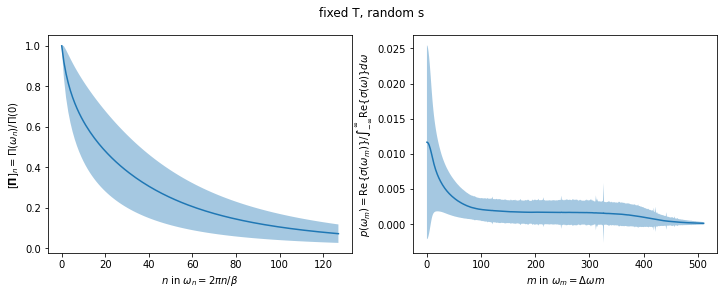

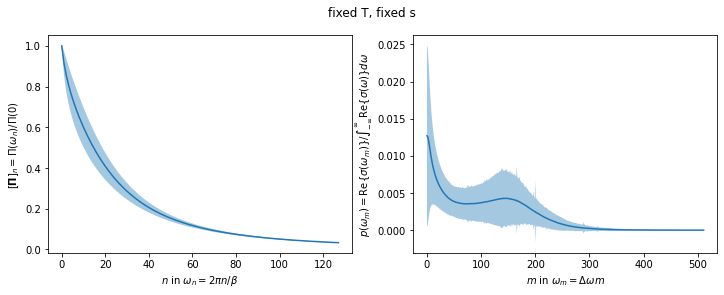

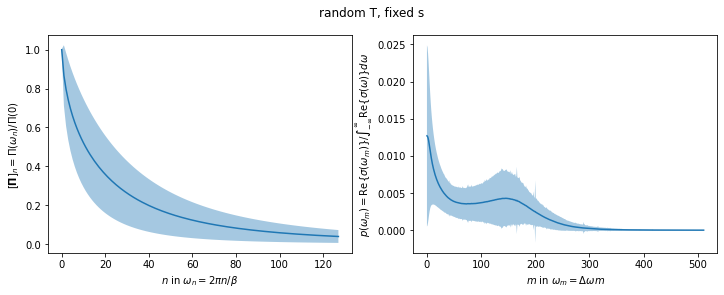

In [12]:
def plot_dataset_stats(sigma, pi, label):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    y = pi
    avg = pi.mean(0)
    std = pi.std(0)
    x=np.arange(128)
    ax[0].plot(x, avg, label=key)
    ax[0].fill_between(x, avg-std, avg+std, alpha=0.4)

    y = sigma
    avg = sigma.mean(0)
    std = sigma.std(0)
    x=np.arange(512)
    ax[1].plot(x, avg, label=label)
    ax[1].fill_between(x, avg-std, avg+std, alpha=0.4)

    ax[0].set_xlabel(r"$n$ in $\omega_n = 2\pi n / \beta$")
    ax[0].set_ylabel(r"$[{\bf \Pi}]_n = \Pi(\omega_n)/\Pi(0)$")
    ax[1].set_xlabel(r"$m$ in $\omega_m = \Delta\omega m$")
    ax[1].set_ylabel(r"$p(\omega_m) = {\rm Re}\{\sigma(\omega_m)\} / \int_{-\infty}^{\infty} {\rm Re}\{\sigma(\omega)\} d\omega$")
    plt.suptitle(key)
    plt.show()


for key in pi:
    plot_dataset_stats(sigma[key], pi[key], label=key)

## Spurious correlation

The fixed T scheme always lead to spurious correlations. To reveal these correlation, we split the dataset accordint to the original second moment of randomly generated conductivities (right), and see where those end up in the input space (left).

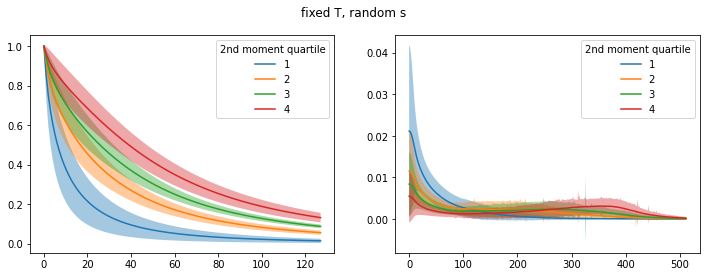

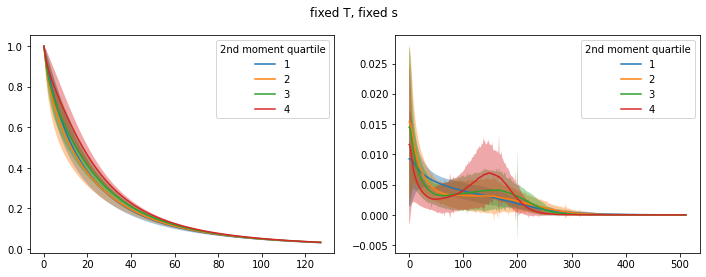

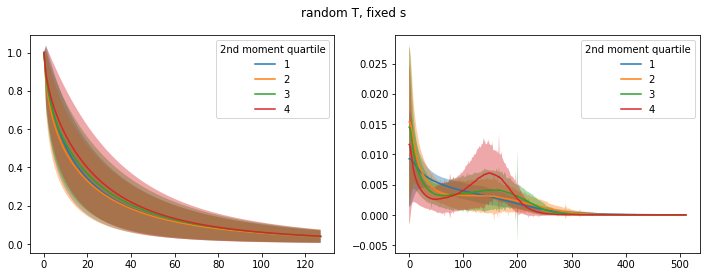

In [21]:
def plot_datasets_stats_by_quartiles(sigma, pi, split_by, split_label="2nd moment quartile"):
    quartiles = [
        np.quantile(split_by, 0),
        np.quantile(split_by, 0.25),
        np.quantile(split_by, 0.5),
        np.quantile(split_by, 0.75),
        np.quantile(split_by, 1)
    ]
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i in range(len(quartiles)-1):
        lb = quartiles[i]
        ub = quartiles[i+1]
        mask = np.logical_and(lb<split_by, split_by<ub)
        # print(f"{mask.sum():5.0f} between {lb:.2f} and {ub:.2f}")
        
        y = pi[mask,:]
        avg = pi[mask].mean(0)
        std = pi[mask].std(0)
        x=np.arange(128)
        ax[0].plot(x, avg, label=i+1)
        ax[0].fill_between(x, avg-std, avg+std, alpha=0.4)

        y = sigma[mask,:]
        avg = sigma[mask].mean(0)
        std = sigma[mask].std(0)
        x=np.arange(512)
        ax[1].plot(x, avg, label=i+1)
        ax[1].fill_between(x, avg-std, avg+std, alpha=0.4)
        
    ax[0].legend(title=split_label)
    ax[1].legend(title=split_label)
    plt.suptitle(key)
    plt.show()

for key in sigma:
    plot_datasets_stats_by_quartiles(sigma[key], pi[key], scale)
    

In the above, we clearly see that the shape of the output (right) is correlated to its second moment (top-row). This leads to a correlation with the decrease rate of the input, unless we fix the second moment before computing that input (middle-row). However, to preserve satisfying coverage of the input space, we need to randomize the temperature (bottom-row).

## Limiting case of a single $p(\omega)$

Here is one particularly clear illustration of the spurious correlation problem with fixed $T$ scheme. Consider the case of a single reference conductivity function, for which we produce a dataset of 10 000 input-ouput-pairs by simply fixing its second moment randomly.

In [14]:
!python3 ../deep_continuation/dataset.py --size 1 --num_std 10000 --seed 55555 --fixstd [1,18] --beta 30;

100%|█████████████████████████████████████| 10000/10000 [03:49<00:00, 43.61it/s]


A comparable dataset in the fixed $s$ scheme can be obtained with 10 000 temperatures for the same $p(\omega)$.

In [16]:
!python3 ../deep_continuation/dataset.py --size 1 --num_beta 10000 --seed 55555 --fixstd 8.86 --beta [0,60];

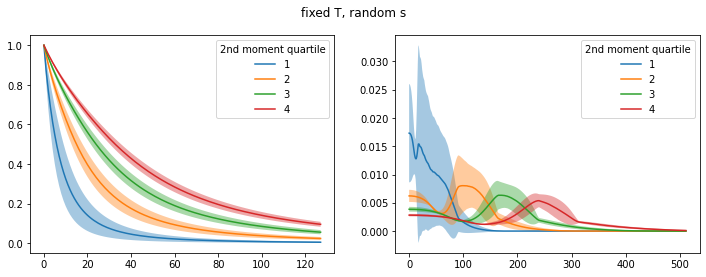

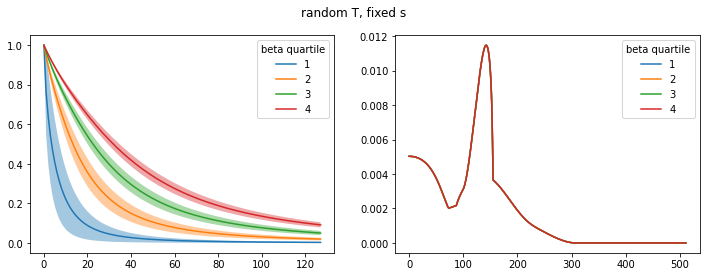

In [22]:
pathological_pi = {}
pathological_pi['fixed T, random s'] = np.load(os.path.join(DATAPATH, "default", "Pi_1x1x10000_seed55555_Nwn128_beta30_std1to18.npy"))
pathological_pi['random T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "Pi_1x10000x1_seed55555_Nwn128_beta0to60_std8.86.npy"))

pathological_sigma = {}
pathological_sigma['fixed T, random s'] = np.load(os.path.join(DATAPATH, "default", "sigma_1x1x10000_seed55555_Nw512_wmax20_std1to18.npy"))
pathological_sigma['random T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "sigma_1x10000x1_seed55555_Nw512_wmax20_std8.86.npy"))

pathological_split_by = {}
pathological_split_by['fixed T, random s'] = np.load(os.path.join(DATAPATH, "default", "fixstd_1x1x10000_seed55555_std1to18.npy"))
pathological_split_by['random T, fixed s'] = np.load(os.path.join(DATAPATH, "default", "beta_1x10000x1_seed55555_beta0to60.npy"))

split_labels = {}
split_labels['fixed T, random s'] = "2nd moment quartile"
split_labels['random T, fixed s'] = "beta quartile"

for key in pathological_sigma:
    plot_datasets_stats_by_quartiles(pathological_sigma[key], pathological_pi[key], pathological_split_by[key], split_labels[key])

As seen above, the `fixed T, random s` scheme has a broad coverage of inputs that map to a broad coverage of output. However, these output all correspond to the same underlying function. By contrast, the `random T, fixed s` scheme has a equivalently broad coverage of inputs, but they all map to the same output, reflecting the underlying degenerancy properly.

Here is a plot that shows that the `fixed T, random s` truly hides a single underlying function, simply rescaled.

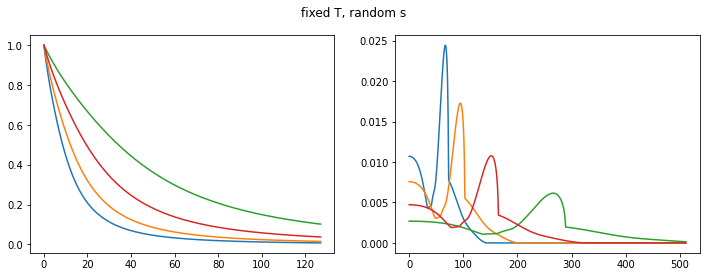

In [34]:
def simple_plot(key, n, start=10):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sigma = pathological_sigma[key]
    pi = pathological_pi[key]
    for i in range(n):
        y = pi[i+start]
        x=np.arange(128)
        ax[0].plot(x, y)

        y = sigma[i+start]
        x=np.arange(512)
        ax[1].plot(x, y)
        
    plt.suptitle(key)
    plt.show()

simple_plot('fixed T, random s', 4)

This reveals another advantage of using the `random T, fixed s` scheme, namely that the width of the output is always the same, so all the components of the output vector can be used, instead of only a small number of them when the function is narrow.